Matthieu Antony, in AEDES, developed an algorithm to orient the program's supervision. This algorithm works in six steps :

1. Computation of aggregate level of payment diminution for each indicator
2. Determination of a subset of N indicators that cause most of payment diminutions
3. Computation of a weighted correction rate of these indicators for each facility, using a priori weights displaying the qualitative interest of each activity
4. Computation of the weighted correction amount for these indicators for each facility
5. Classification of facilities in three levels of risks, based on their weighted correction rates and correction amounts, and predefined threshold
6. Monthly sampling of each facilities, with different sampling probabilities depending on facilities class

Let's try and replicate his results

In [30]:
import pandas as pd
import pickle
import numpy as np

%matplotlib inline

# For warnings
import warnings
warnings.filterwarnings('ignore')

store = pd.HDFStore('../../data/processed/orbf_benin.h5')
tarifs = store['tarifs']
data = store['data']
store.close()

First let's subset the data to the data reported by the WB Zones de Santé for the year 2016 :

In [31]:
bm_zones =['OUIDAH-KPOMASSE-TORI-BOSSITO', 'BANIKOARA', 'LOKOSSA-ATHIEME' , 'ADJOHOUN-BONOU-DANGBO',       'KOUANDE-OUASSA-PEHUNCO-KEROU','COVE-ZANGNANADO-OUINHI', 'PORTONOVO-AGUEGUES-SEME-PODJI', 'BOHICON-ZAKPOTA-ZOGBODOMEY']

data = data[data.geozone_name.isin(bm_zones)]
data = data[data.period.apply(str).str[0:4] == '2016']

In [32]:
data = data[data.date < '2016-11']

data = data.set_index('indicator_label')

I then want to reproduce the first table in the presentation

In [56]:
## Making payment claimed and verified

data['claimed_payment'] = list(data.indicator_claimed_value * data['indicator_tarif'])
data['verified_payment'] = list(data.indicator_verified_value * data['indicator_tarif'])

## Getting total amount of money the program got back 
def get_ecarts(data):
    return sum(data['indicator_claimed_value'] - data['indicator_verified_value']) / sum(data['indicator_claimed_value'])

def get_revenu_gagne(data):
    return sum(data['indicator_montant'])

def get_volume_financier_recupere(data) :
    return sum(data['claimed_payment'] - data['verified_payment'])

def make_first_table(data):
    col1 = data.groupby(level = 0).apply(get_ecarts)
    col2 = data.groupby(level = 0).apply(get_revenu_gagne)
    col3 = data.groupby(level = 0).apply(get_volume_financier_recupere)
    col4 = col3 / get_volume_financier_recupere(data)
    
    
    output = col1.to_frame()
    output.columns = ['Ecarts']
    output['Revenus Totaux Gagnés'] = col2
    output['Volume Financier Récupéré'] = col3
    output['% Volume Financier Récupéré'] = col4
   
    output = output.sort_values('% Volume Financier Récupéré' , ascending = False)
    output['% Cumulé'] = output['% Volume Financier Récupéré'].cumsum()
    return output


a = make_first_table(data)
a

,Ecarts,Revenus Totaux Gagnés,Volume Financier Récupéré,% Volume Financier Récupéré,% Cumulé
indicator_label,,,,,
Enfants completement vaccines,0.054820,171777000.0,9963000.0,0.148810,0.148810
"CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)",0.072376,113312500.0,8841000.0,0.132051,0.280861
Accouchement eutocique assiste,0.024216,315502500.0,7837500.0,0.117063,0.397924
Consultation postnatale 1 (du 7ème au 10ème jour),0.063491,84150500.0,5705000.0,0.085211,0.483136
Diagnostic et traitement des cas de paludisme sévère chez les enfants,0.143090,31004960.0,5177310.0,0.077330,0.560465
Consultation prenatale quatrieme visite standard,0.078630,59154000.0,5049000.0,0.075413,0.635878
Nouvelle Consultation Curative,0.017588,177631300.0,3180100.0,0.047499,0.683377
Accouchement: reference d'urgence pour accouchement,0.230347,9714600.0,2907450.0,0.043426,0.726804
Vaccination au BCG,0.043521,56633500.0,2576875.0,0.038489,0.765292


In [63]:
a

,Ecarts,Revenus Totaux Gagnés,Volume Financier Récupéré,% Volume Financier Récupéré,% Cumulé
indicator_label,,,,,
Enfants completement vaccines,0.054820,171777000.0,9963000.0,0.148810,0.148810
"CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)",0.072376,113312500.0,8841000.0,0.132051,0.280861
Accouchement eutocique assiste,0.024216,315502500.0,7837500.0,0.117063,0.397924
Consultation postnatale 1 (du 7ème au 10ème jour),0.063491,84150500.0,5705000.0,0.085211,0.483136
Diagnostic et traitement des cas de paludisme sévère chez les enfants,0.143090,31004960.0,5177310.0,0.077330,0.560465
Consultation prenatale quatrieme visite standard,0.078630,59154000.0,5049000.0,0.075413,0.635878
Nouvelle Consultation Curative,0.017588,177631300.0,3180100.0,0.047499,0.683377
Accouchement: reference d'urgence pour accouchement,0.230347,9714600.0,2907450.0,0.043426,0.726804
Vaccination au BCG,0.043521,56633500.0,2576875.0,0.038489,0.765292


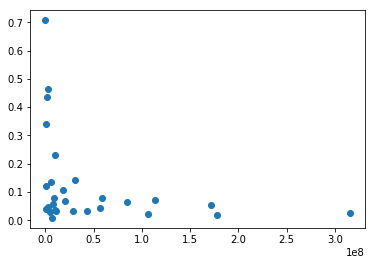

In [70]:
plt.plot(a['Revenus Totaux Gagnés'] , a['Ecarts'] , 'o')